In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

c:\Users\yahya\Desktop\MR Project\Code\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
data = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
data2 = yf.download("^GSPC", start="2024-01-01", end="2025-01-01")

C:\Users\yahya\AppData\Local\Temp\ipykernel_22144\2141739545.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\yahya\AppData\Local\Temp\ipykernel_22144\2141739545.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data2 = yf.download("^GSPC", start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [4]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000
2023-12-28,4783.350098,4793.299805,4780.979980,4786.439941,2698860000
2023-12-29,4769.830078,4788.430176,4751.990234,4782.879883,3126060000


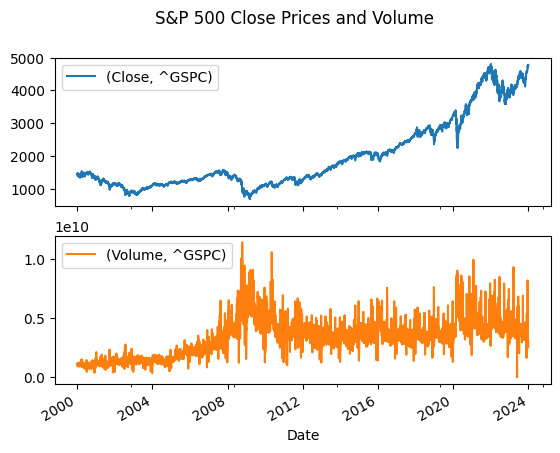

In [5]:
df = data[["Close", "Volume"]].copy()
df2 = data2[["Close", "Volume"]].copy()
df.plot(subplots=True, title="S&P 500 Close Prices and Volume")
plt.show()

In [6]:
df.head()

Price,Close,Volume
Ticker,^GSPC,^GSPC
Date,,
2000-01-03,1455.219971,931800000
2000-01-04,1399.420044,1009000000
2000-01-05,1402.109985,1085500000
2000-01-06,1403.449951,1092300000
2000-01-07,1441.469971,1225200000


In [7]:
df.columns = ["Close", "Volume"]
df2.columns = ["Close", "Volume"]

In [8]:
df[df["Volume"] == 0]
df2[df2["Volume"] == 0]

,Close,Volume
Date,,


In [9]:
print(df[df["Volume"] == 0].count())
df["Volume"] = df["Volume"].replace(0, np.nan)
df["Volume"] = df["Volume"].interpolate(method="linear")
print(df[df["Volume"] == 0].count())

Close     1
Volume    1
dtype: int64
Close     0
Volume    0
dtype: int64


In [10]:
print(df2[df2["Volume"] == 0].count())
# df2["Volume"] = df2["Volume"].replace(0, np.nan)
# df2["Volume"] = df2["Volume"].interpolate(method='linear')
# print(df2[df2["Volume"] == 0].count())

Close     0
Volume    0
dtype: int64


In [11]:
# df[["Close"]].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=5)).std().plot(title="5-Day Rolling Standard Deviation of Close Prices")
# df[["Close"]].rolling(window=5).std().plot(title="5-Day Rolling Standard Deviation of Close Prices")

In [12]:
df["Log_Ret"] = np.log(df["Close"] / df["Close"].shift(1)).copy()

df["Volatility"] = (df["Log_Ret"].rolling(window=21).std() * np.sqrt(252)).copy()

log_vol_chg_coef = 1e-9
df["Log_Vol_Chg"] = np.log(
    (df["Volume"] + 1e-9) / (df["Volume"].shift(1) + 1e-9)
).copy()

HORIZON = 21

df.head()

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2000-01-03,1455.219971,9.318000e+08,NaN,NaN,NaN
2000-01-04,1399.420044,1.009000e+09,-0.039099,NaN,0.079597
2000-01-05,1402.109985,1.085500e+09,0.001920,NaN,0.073081
2000-01-06,1403.449951,1.092300e+09,0.000955,NaN,0.006245
2000-01-07,1441.469971,1.225200e+09,0.026730,NaN,0.114819


In [13]:
window = 21

df2["Log_Ret"] = np.log(df2["Close"] / df2["Close"].shift(1)).copy()
df2["Volatility"] = (df2["Log_Ret"].rolling(window=window).std() * np.sqrt(252)).copy()

log_vol_chg_coef = 1e-9
df2["Log_Vol_Chg"] = np.log(
    (df2["Volume"] + 1e-9) / (df2["Volume"].shift(1) + 1e-9)
).copy()
df2.head()

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2024-01-02,4742.830078,3743050000,NaN,NaN,NaN
2024-01-03,4704.810059,3950760000,-0.008049,NaN,0.054007
2024-01-04,4688.680176,3715480000,-0.003434,NaN,-0.061400
2024-01-05,4697.240234,3844370000,0.001824,NaN,0.034102
2024-01-08,4763.540039,3742320000,0.014016,NaN,-0.026904


In [14]:
df = df.dropna()
df

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2000-02-02,1409.119995,1.038600e+09,-0.000114,0.257009,0.057056
2000-02-03,1424.969971,1.146500e+09,0.011185,0.220892,0.098840
2000-02-04,1424.369995,1.045100e+09,-0.000421,0.220900,-0.092601
2000-02-07,1424.239990,9.181000e+08,-0.000091,0.220917,-0.129562
2000-02-08,1441.719971,1.047700e+09,0.012198,0.204466,0.132046
...,...,...,...,...,...
2023-12-22,4754.629883,3.046770e+09,0.001659,0.094026,-0.118822
2023-12-26,4774.750000,2.513910e+09,0.004223,0.094171,-0.192243
2023-12-27,4781.580078,2.748450e+09,0.001429,0.093012,0.089198


In [15]:
df2 = df2.dropna()
df2

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2024-02-01,4906.189941,4386090000,0.012416,0.114800,-0.068298
2024-02-02,4958.609863,3974350000,0.010628,0.113216,-0.098577
2024-02-05,4942.810059,4023640000,-0.003191,0.113058,0.012326
2024-02-06,4954.229980,4440880000,0.002308,0.113034,0.098666
2024-02-07,4995.060059,4895590000,0.008208,0.107244,0.097482
...,...,...,...,...,...
2024-12-24,6040.040039,1757720000,0.010982,0.137112,-0.715048
2024-12-26,6037.589844,2904530000,-0.000406,0.136852,0.502254
2024-12-27,5970.839844,3159610000,-0.011117,0.140977,0.084177


In [16]:
print(df.isna().sum())
df.interpolate(inplace=True)
print(df.isna().sum())

Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64
Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64


C:\Users\yahya\AppData\Local\Temp\ipykernel_22144\3113013168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(inplace=True)


In [17]:
print(df2.isna().sum())
# df.interpolate(inplace=True)
# print(df.isna().sum())

Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64


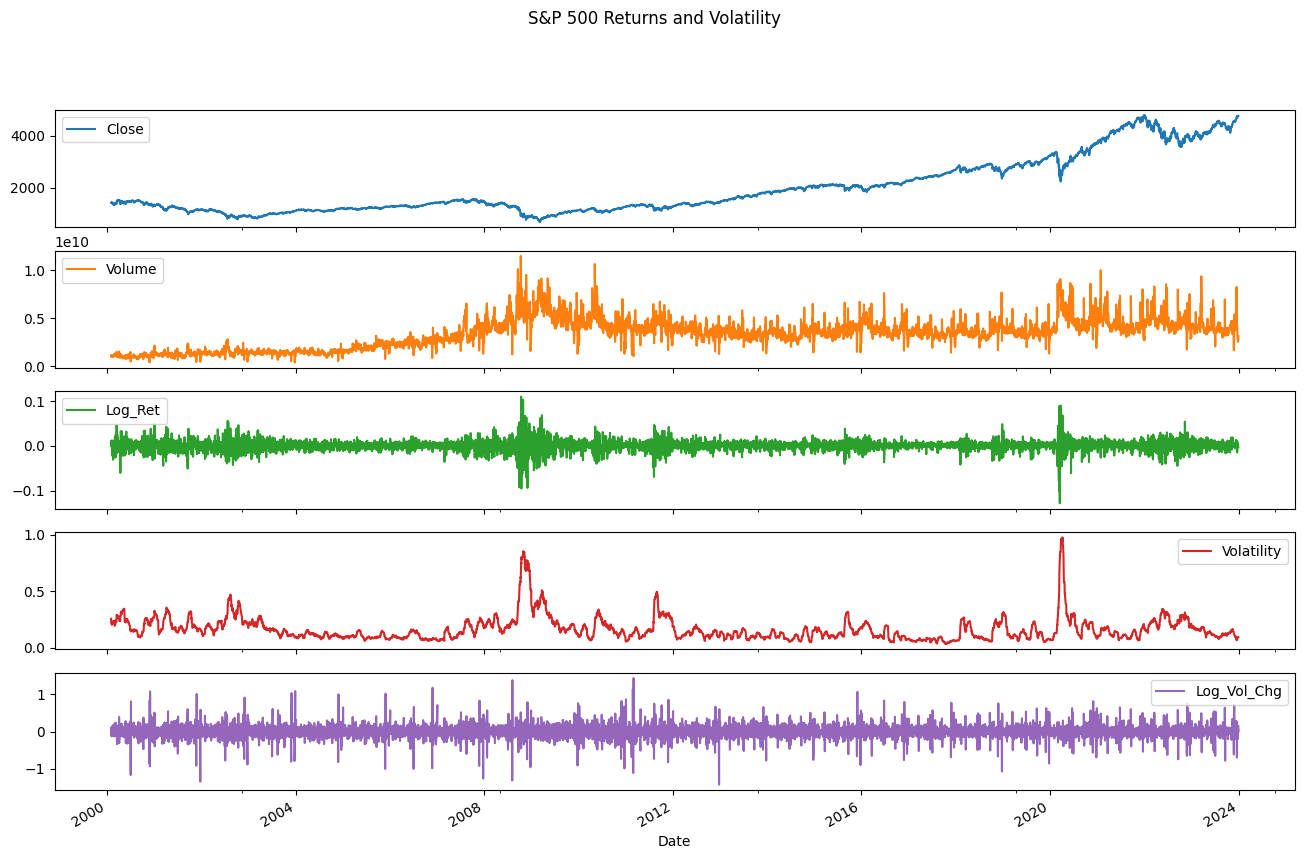

In [18]:
df.plot(subplots=True, title="S&P 500 Returns and Volatility", figsize=(16, 10))
plt.show()

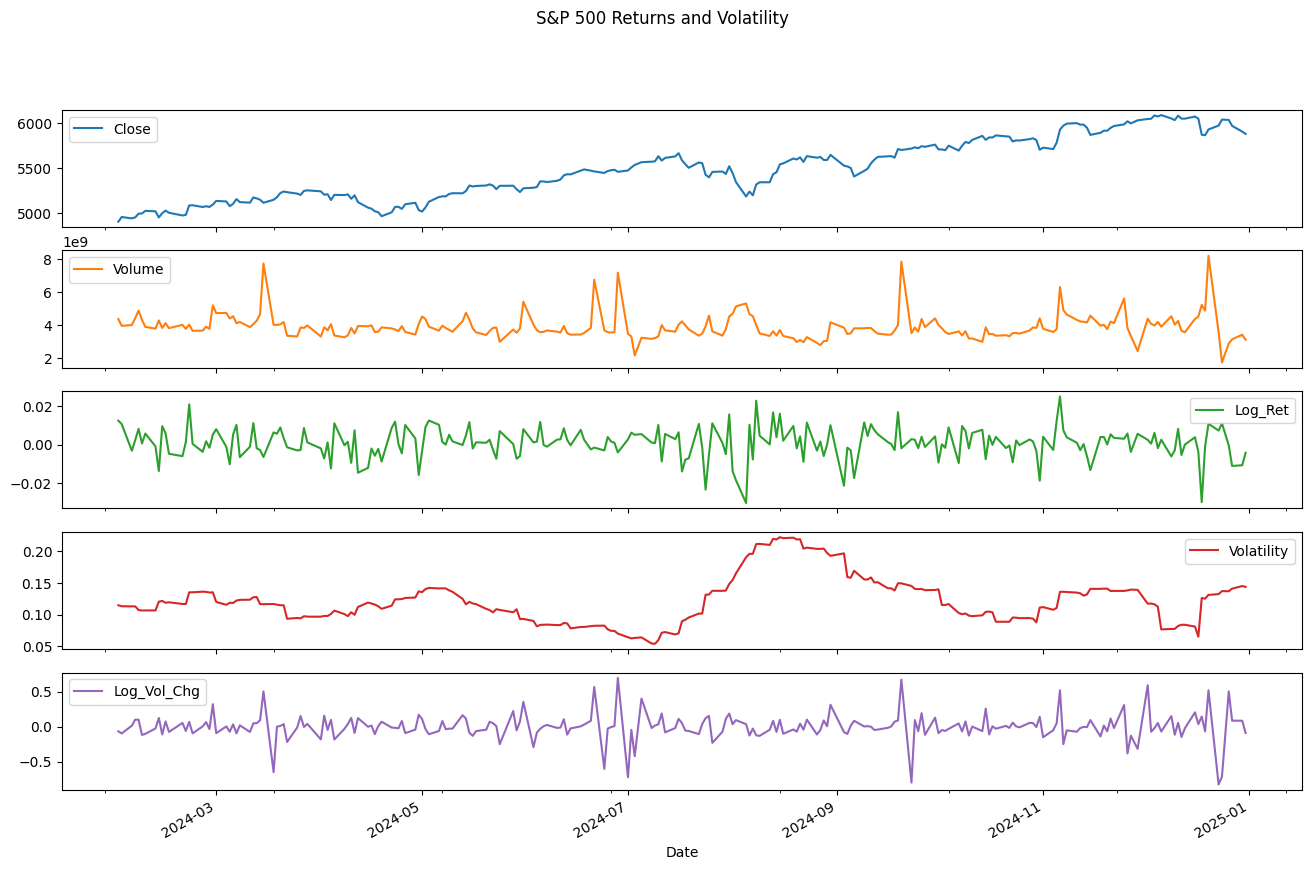

In [19]:
df2.plot(subplots=True, title="S&P 500 Returns and Volatility", figsize=(16, 10))
plt.show()

In [20]:
# df[
#     (df.index <= pd.Timestamp("2023-05-30")) & (df.index >= pd.Timestamp("2023-05-21"))
# ]
# # .plot(subplots=True, title="S&P 500 Returns and Volatility (2023)", figsize=(16, 10))

In [21]:
for col in df.columns[:]:
    print(f"{col} - Mean: {df[col].mean()}, Std: {df[col].std()}")
    print("ADF Test:")
    result = adfuller(df[col])
    print(f"\tADF Statistic: {result[0]}")
    print(f"\tp-value: {result[1]}")
    print(f"\tUsed Lag: {result[2]}")
    print(f"\tnobs: {result[3]}")
    # print(f"\tCritical Values:")
    # for key, value in result[4].items():
    #     print(f"\t   {key}: {value}")
    # print("\n")

Close - Mean: 1975.5021639580423, Std: 1062.689392288297
ADF Test:
	ADF Statistic: 1.5606043771122435
	p-value: 0.9977344380716334
	Used Lag: 32
	nobs: 5983
Volume - Mean: 3335258967.75266, Std: 1506055524.6741881
ADF Test:
	ADF Statistic: -3.0581857639046546
	p-value: 0.029806404190163883
	Used Lag: 32
	nobs: 5983
Log_Ret - Mean: 0.0002026648478674413, Std: 0.01236457631899962
ADF Test:
	ADF Statistic: -18.605065777536048
	p-value: 2.0675517862461503e-30
	Used Lag: 17
	nobs: 5998
Volatility - Mean: 0.1657256148491559, Std: 0.10779341192460061
ADF Test:
	ADF Statistic: -6.596890374320472
	p-value: 6.889560145760304e-09
	Used Lag: 29
	nobs: 5986
Log_Vol_Chg - Mean: 0.00019264565244179308, Std: 0.1860497605895532
ADF Test:
	ADF Statistic: -21.83616369283297
	p-value: 0.0
	Used Lag: 31
	nobs: 5984


In [22]:
def create_sequences(
    data: pd.DataFrame, lookback: int, horizon: int
) -> tuple[np.ndarray, np.ndarray]:
    """Create sequences of data for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing features.
        lookback (int): The number of past timesteps to include in each input sequence.
        horizon (int): The number of future timesteps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The input sequences (X) and the corresponding targets (y).
    """
    X, y = [], []

    feature_cols = ["Log_Ret", "Volatility", "Log_Vol_Chg"]
    data_values = data[feature_cols].values

    for i in range(len(data) - lookback - horizon):
        window = data_values[i : i + lookback]
        future_window = data_values[i + lookback : i + lookback + horizon, 1]

        X.append(window)
        y.append(future_window)

    return np.array(X), np.array(y)


X_raw, y_raw = create_sequences(df, lookback=window * 4, horizon=window)

print(f"Created {X_raw.shape[0]} sequences.")
print(f"X shape: {X_raw.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw.shape}  (Samples, Horizon)")

Created 5911 sequences.
X shape: (5911, 84, 3)  (Samples, Timesteps, Features)
y shape: (5911, 21)  (Samples, Horizon)


In [23]:
X_raw2, y_raw2 = create_sequences(df2, lookback=window * 4, horizon=window)
print(f"Created {X_raw2.shape[0]} sequences.")
print(f"X shape: {X_raw2.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw2.shape}  (Samples, Horizon)")

Created 126 sequences.
X shape: (126, 84, 3)  (Samples, Timesteps, Features)
y shape: (126, 21)  (Samples, Horizon)


In [24]:
n_sep = int(0.8 * X_raw.shape[0])
X_train_raw, X_test_raw = X_raw[:n_sep], X_raw[n_sep:]
y_train_raw, y_test_raw = y_raw[:n_sep], y_raw[n_sep:]

scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])

X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train_raw.shape)
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).reshape(
    y_train_raw.shape
)

X_test_flat = X_test_raw.reshape(-1, X_test_raw.shape[-1])

X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test_raw.shape)
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).reshape(y_test_raw.shape)

print("Data shapes:")
print("Raw Data:")
print(f"Training set: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"Test set: X={X_test_raw.shape}, y={y_test_raw.shape}")

print("Scaled Data:")
print(f"Training set: X={X_train_scaled.shape}, y={y_train_scaled.shape}")
print(f"Test set: X={X_test_scaled.shape}, y={y_test_scaled.shape}")

Data shapes:
Raw Data:
Training set: X=(4728, 84, 3), y=(4728, 21)
Test set: X=(1183, 84, 3), y=(1183, 21)
Scaled Data:
Training set: X=(4728, 84, 3), y=(4728, 21)
Test set: X=(1183, 84, 3), y=(1183, 21)


In [25]:
# -- --- IGNORE ---
# -- --- IGNORE ---

n_sep = int(X_raw2.shape[0] * 1)

X_train_raw2 = X_raw2[:n_sep]
y_train_raw2 = y_raw2[:n_sep]
# X_test_raw2 = X_raw2[n_sep:]
# y_test_raw2 = y_raw2[n_sep:]

print(f"Training set: X={X_train_raw2.shape}, y={y_train_raw2.shape}")
# print(f"Test set: X={X_test_raw2.shape}, y={y_test_raw2.shape}")

scaler_X2 = MinMaxScaler(feature_range=(-1, 1))
scaler_y2 = MinMaxScaler(feature_range=(-1, 1))

X_train_flat2 = X_train_raw2.reshape(-1, X_train_raw2.shape[-1])

scaler_X2.fit(X_train_flat2)
# scaler_y2.fit(y_train_raw2.reshape(-1, 1))

X_train_scaled_flat2 = scaler_X.transform(X_train_flat2)
# X_train_scaled_flat2 = scaler_X2.transform(X_train_flat2)
y_train_scaled2 = scaler_y.transform(y_train_raw2.reshape(-1, 1))
# y_train_scaled2 = scaler_y2.transform(y_train_raw2.reshape(-1, 1))

X_train2 = X_train_scaled_flat2.reshape(X_train_raw2.shape)
y_train2 = y_train_scaled2.reshape(y_train_raw2.shape)

# X_test_reshaped2 = X_test_raw2.reshape(-1, X_test_raw2.shape[-1])
# X_test_scaled_flat2 = scaler_X.transform(X_test_reshaped2)
# X_test_scaled_flat2 = scaler_X2.transform(X_test_reshaped2)
# y_test_scaled2 = scaler_y.transform(y_test_raw2.reshape(-1, 1))
# y_test_scaled2 = scaler_y2.transform(y_test_raw2.reshape(-1, 1))

# Reshape X back to 3D for the LSTM
# X_test2 = X_test_scaled_flat2.reshape(X_test_raw2.shape)
# y_test2 = y_test_scaled2.reshape(y_test_raw2.shape)

print(f"Final Input Shape for LSTM: {X_train2.shape}")

# -- --- IGNORE ---
# -- --- IGNORE ---

Training set: X=(126, 84, 3), y=(126, 21)
Final Input Shape for LSTM: (126, 84, 3)


In [26]:
# Define shapes based on your data
INPUT_SHAPE = (window * 4, 3)  # (Window Size, Features)
OUTPUT_SIZE = window  # (Prediction Horizon)

model = Sequential(
    [
        # Input Layer: Matches your (60, 3) shape
        Input(shape=INPUT_SHAPE),
        # LSTM Layer 1: Captures temporal dependencies
        # return_sequences=True is needed if you want to stack another LSTM layer
        LSTM(units=64, return_sequences=True),
        # Prevents overfitting on noisy financial data
        Dropout(0.2),
        # LSTM Layer 2: Compresses the sequence information
        # return_sequences=False because we now want to transition to the dense output
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        # Dense Layer: Interprets the LSTM features
        Dense(16, activation="relu"),
        # Output Layer: Matches your target shape (5 predictions)
        # Activation is 'linear' (default) for regression
        Dense(OUTPUT_SIZE),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 84, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,709 (119.96 KB)

 Trainable params: 30,709 (119.96 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Stop training if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.2798 - mae: 0.4349 - val_loss: 0.0849 - val_mae: 0.1877
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0420 - mae: 0.1525 - val_loss: 0.0479 - val_mae: 0.1247
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0276 - mae: 0.1222 - val_loss: 0.0408 - val_mae: 0.1084
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - loss: 0.0226 - mae: 0.1096 - val_loss: 0.0359 - val_mae: 0.0989
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - loss: 0.0209 - mae: 0.1061 - val_loss: 0.0370 - val_mae: 0.1023
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0188 - mae: 0.1004 - val_loss: 0.0370 - val_mae: 0.1040
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 0.0178 - mae: 0.0970 - val_loss: 0.0378 - val_mae: 0.0985
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0168 - mae: 0.0935 - val_loss: 0.0380 - val_mae: 0.0979
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step -

In [28]:
# 1. Generate predictions on the test set
y_pred_scaled: np.ndarray = model.predict(X_test_scaled)

# 2. Inverse Transform to get "Real" Volatility
# We must reshape to (-1, 1) because the scaler expects 1 feature column
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(
    y_pred_scaled.shape
)
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(
    y_test_scaled.shape
)


y_pred_df = pd.DataFrame(
    y_pred[:, 0], index=df.index[-y_pred.shape[0] :], columns=["Predicted_Volatility"]
)
y_test_df = pd.DataFrame(
    y_test[:, 0], index=df.index[-y_test.shape[0] :], columns=["Actual_Volatility"]
)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


<Figure size 1400x600 with 0 Axes>

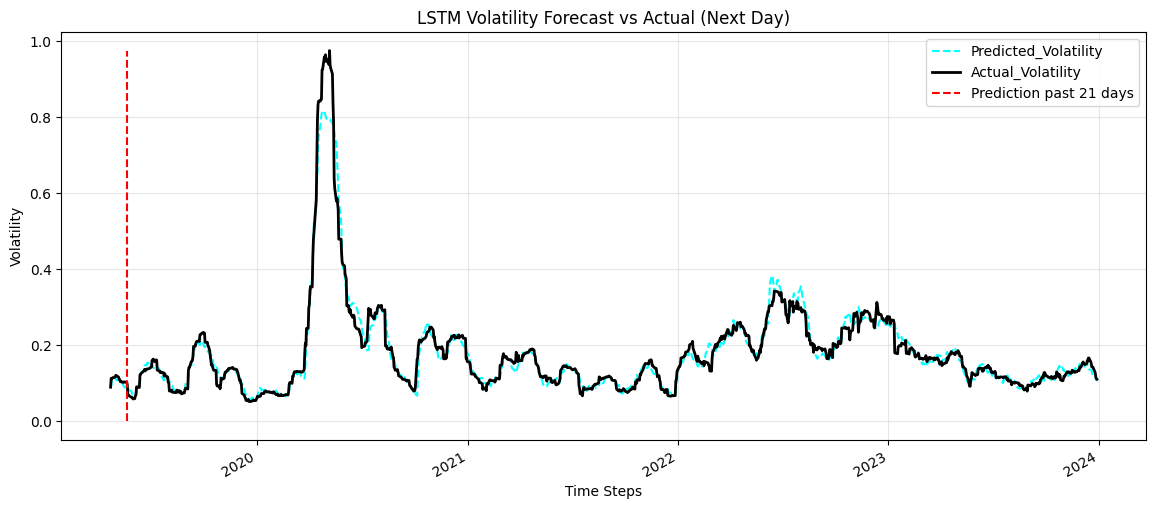

Sample 10 Actual 21-Day Vol:    [0.11634737 0.11083017 0.10972259 0.1045044  0.10460531]...
Sample 10 Predicted 21-Day Vol: [0.10981166 0.11192945 0.11063466 0.1115967  0.10883427]...


In [29]:
# 3. Visualization
# Let's plot the prediction for "Day 1" (Next Day Volatility)
plt.figure(figsize=(14, 6))

# Plotting the first 150 days for clarity (plotting all 1000+ points gets messy)
limit = 2000

fig, ax = plt.subplots(figsize=(14, 6))
y_pred_df.plot(
    ax=ax, label="LSTM Prediction (t+1)", color="cyan", linestyle="--", legend=True
)
y_test_df.plot(
    ax=ax, label="Actual Volatility (t+1)", color="black", linewidth=2, legend=True
)
# plt.plot(y_test[:limit, 0], label='Actual Volatility (t+1)', color='black', linewidth=2)
# plt.plot(y_pred[:limit, 0], label='LSTM Prediction (t+1)', color='cyan', linestyle='--')

plt.title("LSTM Volatility Forecast vs Actual (Next Day)")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.vlines(
    x=df.index[-y_pred.shape[0] + window],
    ymin=0,
    ymax=max(
        max(y_test_df["Actual_Volatility"][:limit]),
        max(y_pred_df["Predicted_Volatility"][:limit]),
    ),
    colors="red",
    linestyles="dashed",
    label=f"Prediction past {window} days",
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Check the 5-day horizon for a specific sample (e.g., sample #10)
print(f"Sample 10 Actual {window}-Day Vol:    {y_test[10][:5]}...")
print(f"Sample 10 Predicted {window}-Day Vol: {y_pred[10][:5]}...")

In [30]:
# 1. Generate predictions on the test set
y_pred_scaled2 = model.predict(X_train2)

# 2. Inverse Transform to get "Real" Volatility
# We must reshape to (-1, 1) because the scaler expects 1 feature column
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2.reshape(-1, 1)).reshape(
    y_train2.shape
)
y_test2 = y_train_raw2
# y_test_real2 = scaler_y2.inverse_transform(y_train2.reshape(-1, 1)).reshape(y_train2.shape)

y_pred2_df = pd.DataFrame(
    y_pred2[:, 0],
    index=df2.index[-y_pred2.shape[0] :],
    columns=["Predicted_Volatility"],
)
y_test2_df = pd.DataFrame(
    y_test2[:, 0], index=df2.index[-y_pred2.shape[0] :], columns=["Actual_Volatility"]
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<Figure size 1400x600 with 0 Axes>

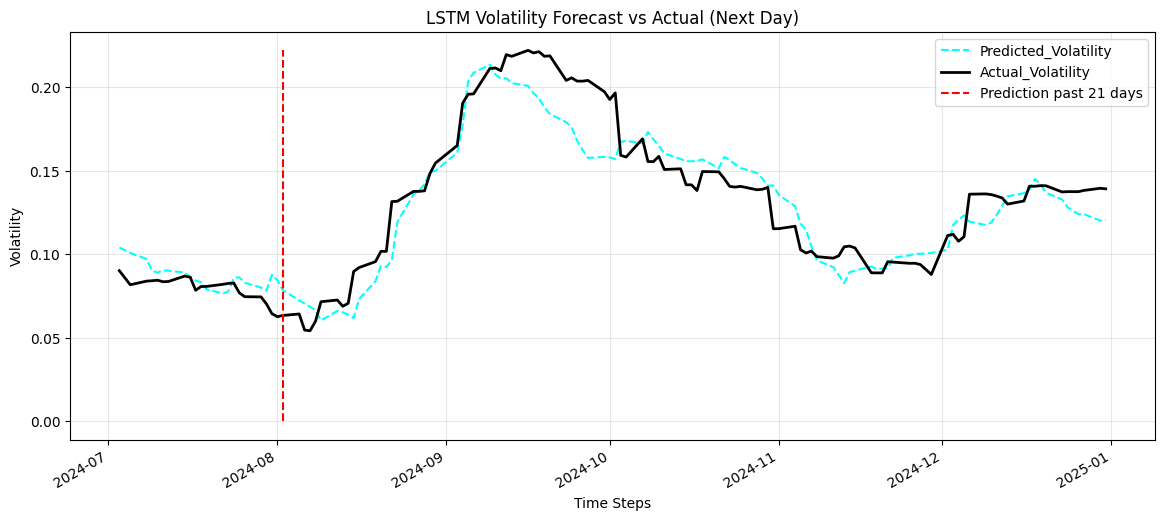

Actual 21-Day Vol:    [0.08063935 0.0806925  0.08194514 0.08250139 0.08272907]...
Predicted 21-Day Vol: [0.08323844 0.08688847 0.08499763 0.08724777 0.08456339]...


In [32]:
# 3. Visualization
# Let's plot the prediction for "Day 1" (Next Day Volatility)
plt.figure(figsize=(14, 6))

# Plotting the first 150 days for clarity (plotting all 1000+ points gets messy)
# limit2 = 150
fig, ax = plt.subplots(figsize=(14, 6))
y_pred2_df.plot(ax=ax, label="Predicted Volatility (t+1)", color="cyan", linestyle="--")
y_test2_df.plot(ax=ax, label="Actual Volatility (t+1)", color="black", linewidth=2)
plt.vlines(
    x=df2.index[-y_pred2.shape[0] + window],
    ymin=0,
    ymax=max(max(y_test2_df.iloc[:, 0]), max(y_pred2_df.iloc[:, 0])),
    colors="red",
    linestyles="dashed",
    label=f"Prediction past {window} days",
)
plt.title("LSTM Volatility Forecast vs Actual (Next Day)")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Check the 5-day horizon for a specific sample (e.g., sample #10)
print(f"Actual {window}-Day Vol:    {y_test2[10][:5]}...")
print(f"Predicted {window}-Day Vol: {y_pred2[10][:5]}...")

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
naive_mse = mean_squared_error(y_test_df[1:], y_test_df.shift(1).dropna())
naive_mae = mean_absolute_error(y_test_df[1:], y_test_df.shift(1).dropna())
naive_r2 = r2_score(y_test_df[1:], y_test_df.shift(1).dropna())
print(f"Naive Baseline RMSE: {np.sqrt(naive_mse)}")
print(f"Naive Baseline MAE: {naive_mae}")
print(f"Naive Baseline R²: {naive_r2}")

print("-"*10)

mse = mean_squared_error(y_test_df, y_pred_df)
mae = mean_absolute_error(y_test_df, y_pred_df)
r2 = r2_score(y_test_df, y_pred_df)
print(f"LSTM Model RMSE: {np.sqrt(mse)}")
print(f"LSTM Model MAE: {mae}")
print(f"LSTM Model R²: {r2}")

Naive Baseline RMSE: 0.013654841794163644
Naive Baseline MAE: 0.006695187161231666
Naive Baseline R²: 0.9882222745129766
----------
LSTM Model RMSE: 0.026200523880997317
LSTM Model MAE: 0.015456738586346545
LSTM Model R²: 0.9566200229847639


In [46]:
naive_mse = mean_squared_error(y_test2_df[1:], y_test2_df.shift(1).dropna())
naive_mae = mean_absolute_error(y_test2_df[1:], y_test2_df.shift(1).dropna())
naive_r2 = r2_score(y_test2_df[1:], y_test2_df.shift(1).dropna())
print(f"Naive Baseline RMSE: {np.sqrt(naive_mse)}")
print(f"Naive Baseline MAE: {naive_mae}")
print(f"Naive Baseline R²: {naive_r2}")

print("-"*10)

mse = mean_squared_error(y_test2_df, y_pred2_df)
mae = mean_absolute_error(y_test2_df, y_pred2_df)
r2 = r2_score(y_test2_df, y_pred2_df)
print(f"LSTM Model RMSE: {np.sqrt(mse)}")
print(f"LSTM Model MAE: {mae}")
print(f"LSTM Model R²: {r2}")

Naive Baseline RMSE: 0.00800400063828257
Naive Baseline MAE: 0.004459322865699207
Naive Baseline R²: 0.9691569644816986
----------
LSTM Model RMSE: 0.015483443720884749
LSTM Model MAE: 0.012039304512949314
LSTM Model R²: 0.8842839906386385
